# Project 2 - Using Feed-Forward Neural Networks for linear and logistic regression
## **Part d)** - Classification analysis with Feed-Forward Neural Network
#### Program imports and defaults

In [1]:
from networkClasses import *
from classSupport import *
from methodSupport import *

import autograd.numpy as anp
from autograd import grad,elementwise_grad
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import roc_auc_score

import pandas as pd

## Random seed
def_seed = 15
np.random.seed(def_seed); anp.random.seed(def_seed)

## Figure defaults
plt.rcParams["figure.figsize"] = (8,3); plt.rcParams["font.size"] = 10

### Dataset: Wisconsin Breast Cancer Dataset
#### Data preprocessing

In [2]:
anp.random.seed(def_seed)

cancer =  load_breast_cancer() #load_iris()
cancerpd = pd.DataFrame(cancer.data, columns=cancer.feature_names)

inputs = cancer.data; targets = cancer.target
'''
num = 15
height = anp.random.normal(1.85,0.075,num)
weight = anp.random.normal(90,25,num)
print(height)
print(weight)

dataset = anp.zeros((num,2))
dataset[:,0] = height
dataset[:,1] = weight
print(dataset)
inputs = dataset
targets = dataset[:,1]/dataset[:,0]
print(targets)
#'''

print('Input data shape   :',inputs.shape)
print('Target matrix shape:',targets.shape)
print('Target names       :',cancer.target_names)
print('Target classes     : [    ',targets.min(),'        ',targets.max(),'  ]') #

#print(cancer.feature_names)
## Train-test splitting
test_size = 1/8
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs,targets,test_size=test_size,random_state=def_seed)
#inputs_train, inputs_test, targets_train, targets_test = inputs,inputs,targets,targets
## Data scaling
scaler = StandardScaler() #StandardScaler() MinMaxScaler()
scaler.fit(inputs_train)
inputs_train_s = scaler.transform(inputs_train)
inputs_test_s = scaler.transform(inputs_test)
#print(scaler.mean_)
#print(scaler.var_)
#print(inputs_test[:5,:5])
#print(inputs_test_s[:5,:5])

Input data shape   : (569, 30)
Target matrix shape: (569,)
Target names       : ['malignant' 'benign']
Target classes     : [     0          1   ]


#### Covariance matrix for the dataset

In [3]:
corr_matrix = cancerpd.corr().round(1)
show = False
if show == True:
    fig,ax = plt.subplots(1,1,figsize=(12,8))
    ax = sns.heatmap(corr_matrix,annot=True)
    
    fig, axes = plt.subplots(15,2,figsize=(10,20))
    malignant = cancer.data[cancer.target == 0]
    benign = cancer.data[cancer.target == 1]
    ax = axes.ravel()

    for i in range(30):
        _, bins = np.histogram(cancer.data[:,i], bins =50)
        ax[i].hist(malignant[:,i], bins = bins, alpha = 0.5)
        ax[i].hist(benign[:,i], bins = bins, alpha = 0.5)
        ax[i].set_title(cancer.feature_names[i])
        ax[i].set_yticks(())
    ax[0].set_xlabel("Feature magnitude")
    ax[0].set_ylabel("Frequency")
    ax[0].legend(["Malignant", "Benign"], loc ="best")
    fig.tight_layout()
    plt.show()

### Feed-Forward Neural Network analysis 
#### Network setup and training with a fixed set of hyperparameters $\eta, \gamma, \lambda$
Simple training of the network with fixed parameters for the learning rate $\eta$, regularization, $\lambda$, gradient momentum, $\gamma$, as well as a fixed number of mini-batches and epochs. Choose gradient descent method by uncommenting on of the `GDMethod`-instances. Full list of available activation functions can be found in the `methodSupport`.

(eta,lmbda) 0.001 1e-09
Prediction accuracy, test data    : 0.9166666666666666
Prediction accuracy, training data: 0.903420523138833
Loss: 0.7230384938945502
Loss: 0.7230384938945502
ROC-AUC: 0.943576


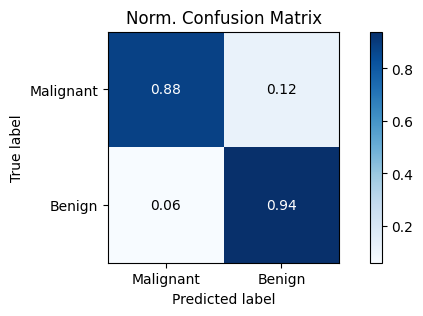

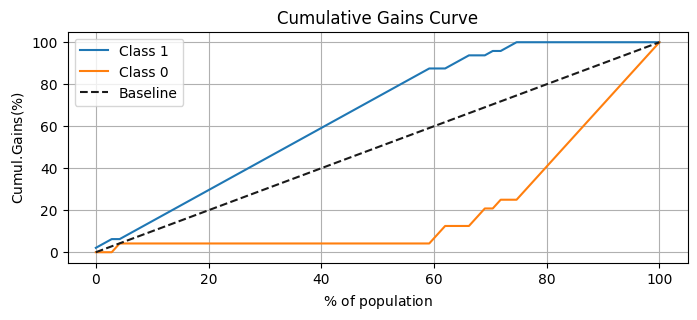

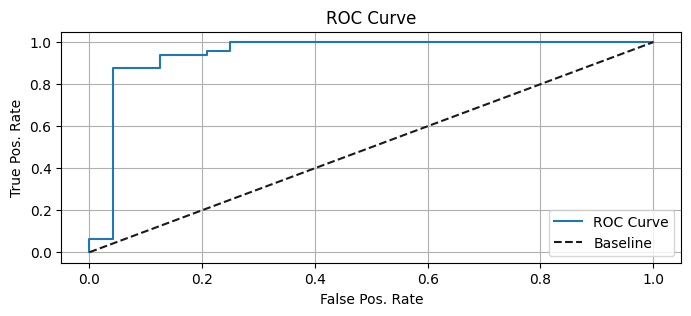

In [40]:
anp.random.seed(def_seed)

n_inputs,n_features = inputs_train_s.shape

layer_output_sizes = [10,5,1]

hidden_func  = sigmoid #sigmoid, ReLU, expReLU, LeakyReLU, identity, tanh
hidden_der = sigmoid_der #
#hidden_der = elementwise_grad(hidden_func)

act_funcs = []; act_ders = []
for i in range(len(layer_output_sizes)-1):
    act_funcs.append(hidden_func)
    act_ders.append(hidden_der)
act_funcs.append(sigmoid); 
output_der = sigmoid_der #elementwise_grad(act_funcs[-1]); 
#output_der = elementwise_grad(act_funcs[-1]); 
act_ders.append(output_der)

cost_func = log_loss
cost_der  = log_loss_der   #grad(cost_func,0) #log_loss_der #grad(cost_func,0)

network_cl = FFNNetwork(network_input_size=n_features,layer_output_size=layer_output_sizes,
                            activation_functions=act_funcs,activation_derivatives=act_ders,
                            cost_function=cost_func,cost_derivative=cost_der,random_state=def_seed)

network_cl.create_layers()

## Gradient Descent setup
eta = 1e-3
gamma = 1e-8
lmbda = 1e-9; lp = 2
decay = 0.9

batches = 16; epoch = 1000

## Calling the gradient descent (GD)-method
#GDMethod = PlainGD(eta,lmbda=lmbda,lp=lp)
#GDMethod = MomentumGD(eta,gamma,lmbda=lmbda,lp=lp)
GDMethod = Adagrad(eta,gamma,lmbda,lp=lp)
#GDMethod = RMSprop(eta,decay=decay)
#GDMethod = ADAM(eta,lmbda=lmbda)


network_cl.train_network(input=inputs_train_s,target=targets_train,GDMethod=GDMethod,
                                batches=batches,epochs=epoch)

final_prediction = network_cl.predict(inputs_test_s,binary=False)
final_prediction_bin = np.zeros_like(final_prediction)
for k in range(len(final_prediction)):
    if final_prediction[k] >= 0.5:
        final_prediction_bin[k] = 1

final_prediction_train = network_cl.predict(inputs_train_s,binary=False)
final_prediction_train_bin = np.zeros_like(final_prediction_train)
for k in range(len(final_prediction_train)):
    if final_prediction_train[k] >= 0.5:
        final_prediction_train_bin[k] = 1

acc = accuracy_score(targets_test,final_prediction_bin)
acc_train = accuracy_score(targets_train,final_prediction_train_bin)
print('(eta,lmbda)',eta,lmbda)
print('Prediction accuracy, test data    :',acc)
print('Prediction accuracy, training data:',acc_train)
print('Loss:',network_cl.cost(inputs_test_s,targets_test))
print('Loss:',log_loss(final_prediction,targets_test))


ax = confusion_roc_cumul_gains(targets_test,final_prediction[:,0],plots='all')
#fig.savefig('confusion_mat.png',dpi=300,bbox_inches='tight')


#### Repeated training with the same parameters as above

In [ ]:
anp.random.seed(def_seed); network_cl.reset()
show = False

'''layer_output_sizes = layer_output_sizes #[15,5,1]

hidden_func  = sigmoid #sigmoid, ReLU, expReLU, LeakyReLU, identity, tanh
hidden_der = sigmoid_der #elementwise_grad(hidden_func)
#hidden_der = elementwise_grad(hidden_func)

act_funcs = []; act_ders = []
for i in range(len(layer_output_sizes)-1):
    act_funcs.append(hidden_func)
    act_ders.append(hidden_der)
act_funcs.append(sigmoid); 
output_der = sigmoid_der #elementwise_grad(act_funcs[-1]); 
#output_der = elementwise_grad(act_funcs[-1]); 
act_ders.append(output_der)

cost_func = log_loss
cost_der  = log_loss_der #grad(cost_func,0)

network_cl = FFNNetwork(network_input_size=n_features,layer_output_size=layer_output_sizes,
                            activation_functions=act_funcs,activation_derivatives=act_ders,
                            cost_function=cost_func,cost_derivative=cost_der,random_state=def_seed)'''

network_cl.create_layers()

## Gradient Descent setup
eta = 1e-3
gamma = 0.000001
lmbda = 0.0#1e-7; lp = 2
gamma = 0.0000001
decay = 0.005

batches = 16; epoch = 1000

## Calling the gradient descent (GD)-method
#GDMethod = PlainGD(eta,lmbda=lmbda,lp=lp)
#GDMethod = MomentumGD(eta,gamma,lmbda=lmbda,lp=lp)
#GDMethod = Adagrad(eta,gamma,lmbda,lp=lp)
#GDMethod = RMSprop(eta,decay=decay)
GDMethod = ADAM(eta,lmbda=lmbda)

loss = 1; tol = 0.05; iter = 0
acc = 0; acc_train = 0; tol_acc = 0.98
#while loss > tol and iter < 1000:
while acc < tol_acc and iter < 10:

    network_cl.train_network(input=inputs_train_s,target=targets_train,GDMethod=GDMethod,
                                batches=batches,epochs=epoch)

    final_prediction_train = network_cl.predict(inputs_train_s)
    final_prediction = network_cl.predict(inputs_test_s) 
    
    loss = network_cl.cost(inputs_train_s,targets_train)
    #mse_train = mse_predict(final_prediction_train,targets_train)
    final_prediction_bin_train = np.zeros_like(final_prediction_train)
    final_prediction_bin = np.zeros_like(final_prediction)
    for k in range(len(final_prediction_train)):
        if final_prediction_train[k] >= 0.5:
            final_prediction_bin_train[k] = 1
    for k in range(len(final_prediction)):
        if final_prediction[k] >= 0.5:
            final_prediction_bin[k] = 1
    acc_train = accuracy_score(targets_train,final_prediction_bin_train)
    acc = accuracy_score(targets_test,final_prediction_bin)

    iter += 1
    if iter % 1 == 0:
        print(iter)
        print('Training loss:',loss)
        print('Test acc:',acc)
        print('Training acc:',acc_train)
    

final_prediction = network_cl.predict(inputs_test_s,binary=False)
final_prediction_bin = np.zeros_like(final_prediction)
for k in range(len(final_prediction)):
    if final_prediction[k] >= 0.5:
        final_prediction_bin[k] = 1

acc = accuracy_score(targets_test,final_prediction_bin)#network_cl.accuracy(final_prediction,targets=targets_test#print('(eta,gamma)',eta[i],gamma[j])
print('Trained %i times' %(iter))
print('(eta,lmbda)',eta,lmbda)
print('Prediction accuracy:',acc)
print('Final loss:',network_cl.cost(inputs_test_s,targets_test))

#print(final_prediction)

ax = confusion_roc_cumul_gains(targets_test,final_prediction[:,0])

#### K-fold cross-validation

In [ ]:
from sklearn.model_selection import KFold
gamma = 0.00001
eta = anp.logspace(-6,-1,10)
lmbdas = anp.logspace(-10,-5,10)
batches = 30
epoch = 100
num_folds = 5
kfold = KFold(n_splits=num_folds)

loss_score, acc_score = {},{}
for i in range(len(lmbdas)):
    scores_eta = anp.zeros((len(eta),num_folds))
    acc_eta = anp.zeros((len(eta),num_folds))
    for j in range(len(eta)):
        
        for k, (tr_idx,te_idx) in enumerate(kfold.split(inputs_train_s)):
            in_tr_k, in_te_k = inputs_train_s[tr_idx], inputs_train_s[te_idx]
            target_tr_k,target_te_k = targets_train[tr_idx], targets_train[te_idx]
            #print(i,j,k)
            network_cl.create_layers()
            GDMethod = ADAM(eta[j],lmbda=lmbdas[i]) #Adagrad(eta[i],gamma,lmbda=lmbda,lp=2)
            network_cl.train_network(in_tr_k,target_tr_k,GDMethod=GDMethod,batches=batches,epochs=epoch)
            
            scores_eta[j,k] = network_cl.cost(in_te_k,target_te_k)
            
            final_prediction = network_cl.predict(in_te_k,binary=False)
            final_prediction_bin = np.zeros_like(final_prediction)
            for p in range(len(final_prediction)):
                if final_prediction[p] >= 0.5:
                    final_prediction_bin[p] = 1
            acc_eta[j,k] = accuracy_score(target_te_k,final_prediction_bin)
    
    loss_score['loss_'+str(i)] = anp.mean(scores_eta,axis=1)
    loss_score['acc_'+str(i)] = anp.mean(acc_eta,axis=1)
        

In [ ]:
mean_scores = anp.mean(scores_eta,axis=1)
acc_score = anp.mean(acc_eta,axis=1)
print(mean_scores.shape)
#print(scores_eta)
#print(len(eta))
plt.plot(anp.log10(eta),acc_score)#mean_scores)
plt.plot(anp.log10(eta),mean_scores)
#plt.plot

#### Parameter study, $\eta$, $\lambda$, $\gamma$

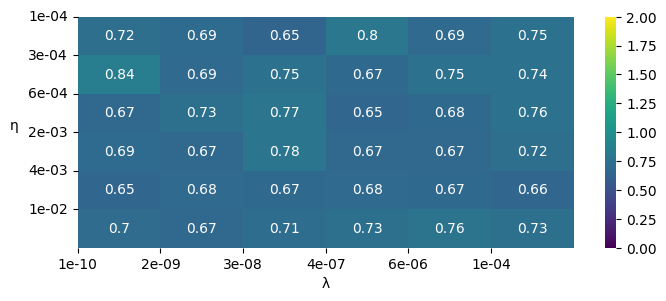

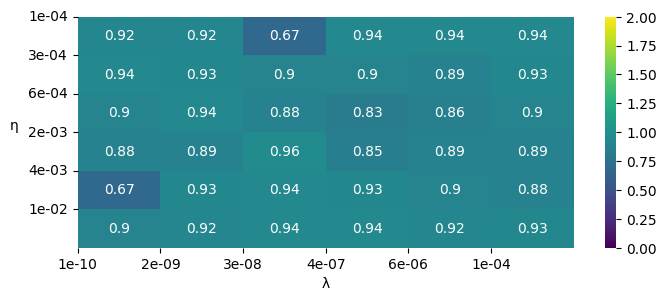

In [41]:
anp.random.seed(def_seed); network_cl.reset()
show = False

## Gradient Descent setup
num_param = 6
eta = anp.logspace(-4,-2,num_param)
#gamma = anp.logspace(-10,-4,num_param)
gamma = 1e-8
lmbda = anp.logspace(-10,-4,num_param)
lp = 2
ADAM_decay = [0.9,0.99]

batches = 16; epoch = 1000

LOSS = anp.zeros((len(eta),len(lmbda)))
ACC = anp.zeros_like(LOSS)
for i in range(len(eta)):
    #for j in range(len(gamma)):
    for j in range(len(lmbda)):

        ## Recreating the layers
        network_cl.create_layers()

        ## Calling the gradient descent (GD)-method
        #GDMethod = [PlainGD(eta[i],lmbda=lmbda[j],lp=lp),PlainGD(eta[i],lmbda=lmbda[j],lp=lp)]
        #GDMethod = [MomentumGD(eta[i],gamma[j],lmbda=lmbda,lp=lp),MomentumGD(eta[i],gamma[j],lmbda=lmbda,lp=lp)]
        GDMethod = Adagrad(eta[i],gamma,lmbda=lmbda[j],lp=lp)
        #GDMethod = RMSprop(eta[i],lmbda[j])
        #GDMethod = ADAM(eta[i],lmbda=lmbda[j])


        network_cl.train_network(input=inputs_train_s,target=targets_train,GDMethod=GDMethod,
                                batches=batches,epochs=epoch)

        final_prediction = network_cl.predict(inputs_test_s,binary=False)
        final_prediction_bin = np.zeros_like(final_prediction)
        
        ## Creating a binary array for the accuracy score
        for k in range(len(final_prediction)):
            if final_prediction[k] >= 0.5:
                final_prediction_bin[k] = 1

        LOSS[i,j] = network_cl.cost(inputs_test_s,targets_test)
        ACC[i,j]  = accuracy_score(targets_test,final_prediction_bin)

        if show == True:
            print(f'{GDMethod.__class__.__name__}')
            #print('(eta,gamma)',eta[i],gamma[j])
            print('(eta,lmbda)',eta[i],lmbda[j])
            print('Prediction accuracy:',acc)
            print('Loss:',network_cl.cost(inputs_test_s,targets_test))

        network_cl.reset()

fig,ax = lambda_eta(LOSS,[lmbda,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[0.,2.]
                    )
fig,bx = lambda_eta(ACC,[lmbda,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[0.,2.]
                    )


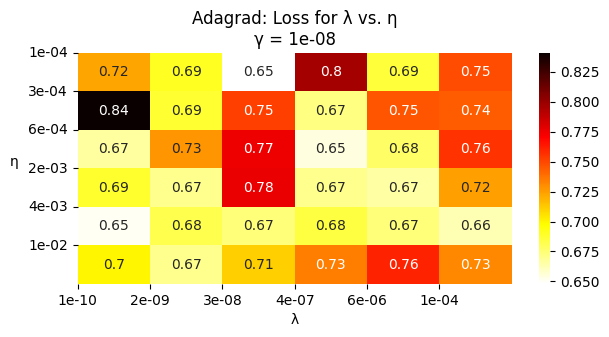

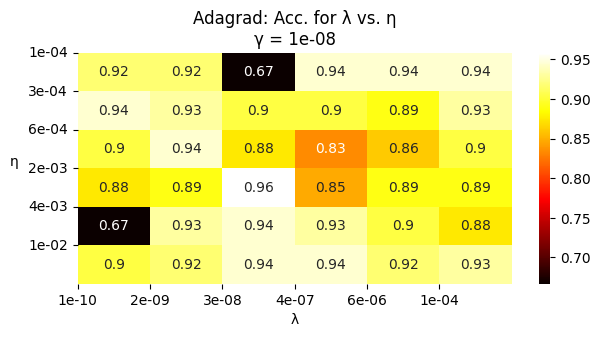

In [42]:
ADAM_decay = [0.9,0.99]
fig,ax = lambda_eta(LOSS,[lmbda,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[LOSS.min(),LOSS.max()],
                    #cbar_lim=[0.0,4.],
                    cmap='hot_r'#,save=True,f_name='grid_search_eta_lamb_ADAM_linreg.png'  #hot
                    )
fig.set_size_inches(7,3)
#ax.set_xlabel('ρ')
#_ = ax.set_title(f'{GDMethod.__class__.__name__}: Loss for λ vs. η\nρ = (%g, %g)' %(ADAM_decay[0],ADAM_decay[1]))
#_ = ax.set_title(f'{GDMethod.__class__.__name__}: Loss for λ vs. η\nρ = %g' %(decay))
_ = ax.set_title(f'{GDMethod.__class__.__name__}: Loss for λ vs. η\nγ = %.0e' %(gamma))

fig0,bx = lambda_eta(ACC,[lmbda,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[ACC.min(),ACC.max()],
                    #cbar_lim=[0.0,4.],
                    cmap='hot'#,save=True,f_name='grid_search_eta_lamb_ADAM_linreg.png'  #hot
                    )
fig0.set_size_inches(7,3)
#ax.set_xlabel('ρ')
#_ = bx.set_title(f'{GDMethod.__class__.__name__}: Acc. for λ vs. η\nρ = %g' %(decay))
_ = bx.set_title(f'{GDMethod.__class__.__name__}: Acc. for λ vs. η\nγ = %.0e' %(gamma))

In [43]:
fig.savefig('grid_search_loss_eta_lmbda_ada_class_m32_e1000_med_range.png',dpi=300,bbox_inches='tight')
fig0.savefig('grid_search_acc_eta_lmbda_ada_class_m32_e1000_med_range.png',dpi=300,bbox_inches='tight')

### Scikit-learn `MLPClassifier`-class

In [ ]:
from sklearn.neural_network import MLPClassifier
layer_output_sizes_sci = [15,10,1]; lmbda = 1e-3
network_sk = MLPClassifier(layer_output_sizes_sci,learning_rate_init=0.001,#learning_rate='constant',
                        activation='logistic',#alpha=lmbda,#batch_size=100,
                        solver='adam',random_state=def_seed,max_iter=2000,)

network_sk.fit(inputs_train_s,targets_train)
final_pred = network_sk.predict(inputs_test_s)

print('Training iterations:',network_sk.n_iter_)
print('Accuracy, test:',network_sk.score(inputs_test_s,targets_test))
print('Accuracy, training:',network_sk.score(inputs_train_s,targets_train))

ax = confusion_roc_cumul_gains(targets_test,final_pred)
plt.figure(figsize=(5,5))
_ = plt.imshow([targets_test,final_pred],aspect='auto')

In [ ]:
'''fig,cx = plt.subplots(1,1,figsize=(5,5))
#_ = plt.imshow([targets_test,final_prediction_bin[:,0]],aspect='auto')
#cx = sns.heatmap([targets_test,final_prediction_bin[:,0]],xticklabels=False,cmap='magma')'''